https://morvanzhou.github.io/tutorials/machine-learning/torch/4-03-RNN-regression/

# 要点

循环神经网络让神经网络有了记忆，对于序列话的数据，循环神经网络能达到更好的效果。

下面使用RNN来及时预测时间序列。

# 训练数据

我们要用到的数据就是这样的一些数据，我们想要用`sin`的曲线预测出`cos`的曲线

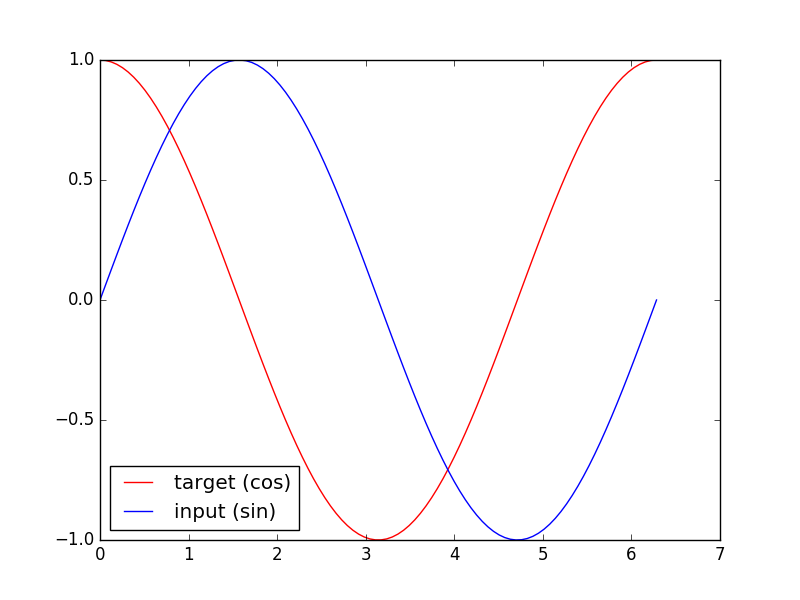

In [1]:
%matplotlib inline
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1)  # reproducible

# hyper Parameters
TIME_STEP=10 # rnn time step / image height
INPUT_SIZE=1 # rnn input size / image width
LR=0.02  # learning rate
DOWNLOAD_MNIST=False  #set to True if haven't download the data

# RNN模型

这一次的 RNN, 我们对每一个 `r_out` 都得放到 `Linear` 中去计算出预测的 `output`, 所以我们能用一个 for loop 来循环计算。

In [2]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        
        self.rnn=nn.RNN( #这回一个普通的RNN就能胜任
            input_size=1, 
            hidden_size=32, # rnn hidden unit
            num_layers=1,   # 有几层 RNN layers
            # input & output会是以batch size 为第一维度的特征集 e.g.(batch, time_step,input_size)
            batch_first=True,
        )
        self.out=nn.Linear(32,1)
        
    def forward(self,x,h_state):
        # 因为hidden state是连续的，所以我们要一直传递这一个state
        # x (batch,time_step,input_size)
        # h_state (n_layers,batch,hidden_size)
        # r_out (batch,time_step,output_size)
        r_out,h_state=self.rnn(x,h_state) # h_state也要作为RNN的一个输入
        
        outs=[] # 保存所有时间点的预测值
        for time_step in range(r_out.size(1)):  #对每一个时间点计算output
            outs.append(self.out(r_out[:,time_step,:]))
        return torch.stack(outs,dim=1),h_state
    
rnn=RNN()
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


其实熟悉 RNN 的朋友应该知道, forward 过程中的对每个时间点求输出还有一招使得计算量比较小的. 不过上面的内容主要是为了呈现 PyTorch 在动态构图上的优势, 所以我用了一个 for loop 来搭建那套输出系统. 下面介绍一个替换方式. 使用 reshape 的方式整批计算.

In [3]:
def forward(self, x, h_state):
    r_out, h_state = self.rnn(x, h_state)
    r_out_reshaped = r_out.view(-1, HIDDEN_SIZE) # to 2D data
    outs = self.linear_layer(r_out_reshaped)
    outs = outs.view(-1, TIME_STEP, INPUT_SIZE)  # to 3D data

# 训练

我们使用 `x` 作为输入的 `sin` 值, 然后 `y` 作为想要拟合的输出, `cos` 值. 因为他们两条曲线是存在某种关系的, 所以我们就能用 `sin` 来预测 `cos`. `rnn` 会理解他们的关系, 并用里面的参数分析出来这个时刻 `sin` 曲线上的点如何对应上 `cos` 曲线上的点.

In [4]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all rnn parameters
loss_func = nn.MSELoss()

h_state = None   # 要使用初始 hidden state, 可以设成 None

for step in range(100):
    start, end = step * np.pi, (step+1)*np.pi   # time steps
    # sin 预测 cos
    steps = np.linspace(start, end, 10, dtype=np.float32)
    x_np = np.sin(steps)    # float32 for converting torch FloatTensor
    y_np = np.cos(steps)

    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis])    # shape (batch, time_step, input_size)
    y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis])

    prediction, h_state = rnn(x, h_state)   # rnn 对于每个 step 的 prediction, 还有最后一个 step 的 h_state
    # !!  下一步十分重要 !!
    h_state = h_state.data  # 要把 h_state 重新包装一下才能放入下一个 iteration, 不然会报错

    loss = loss_func(prediction, y)     # cross entropy loss
    optimizer.zero_grad()               # clear gradients for this training step
    loss.backward()                     # backpropagation, compute gradients
    optimizer.step()                    # apply gradients

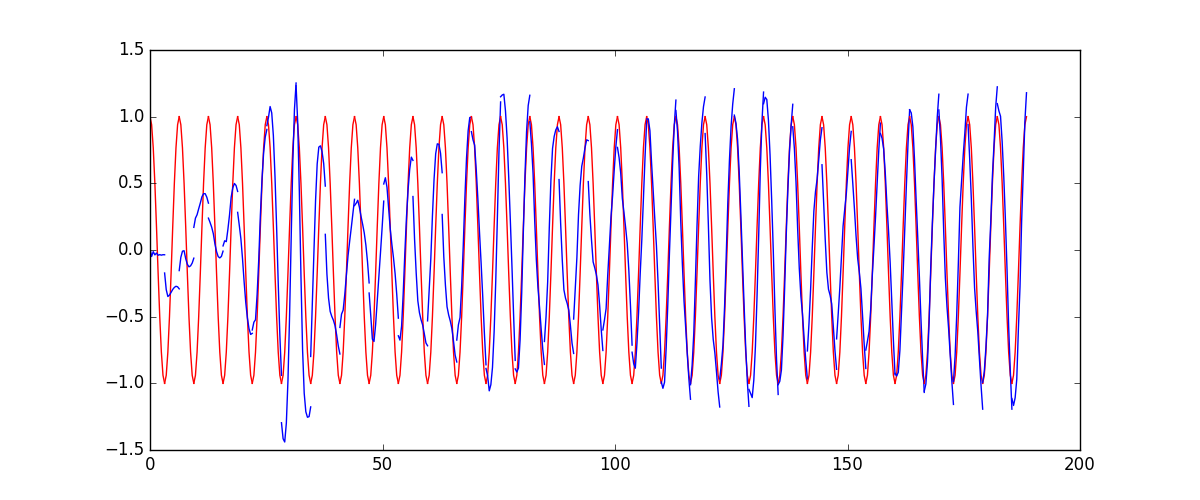

# 完整代码

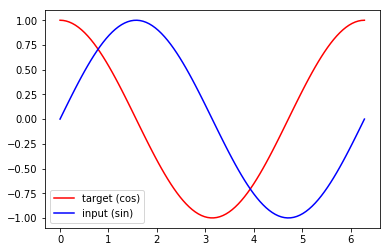

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


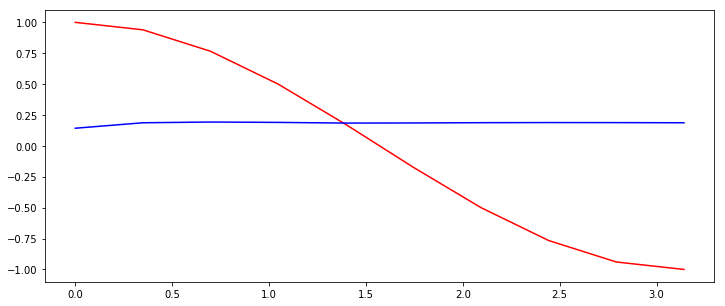

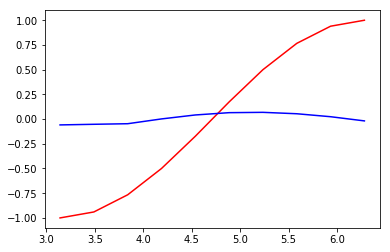

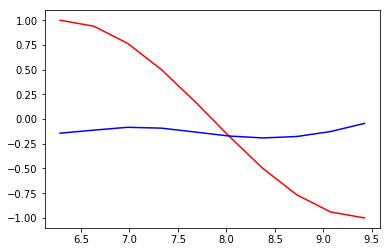

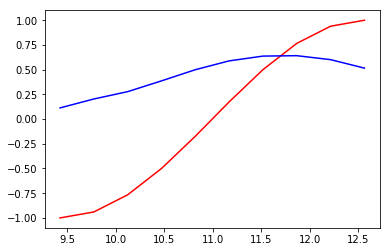

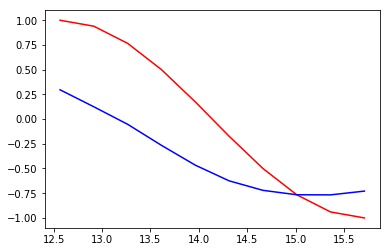

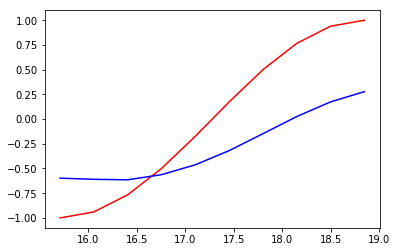

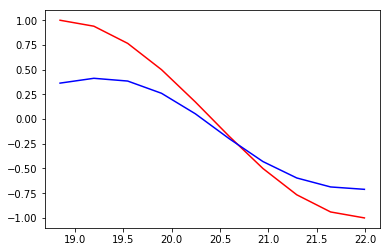

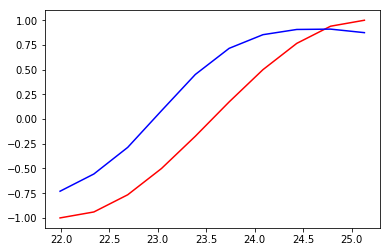

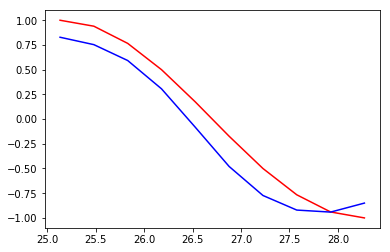

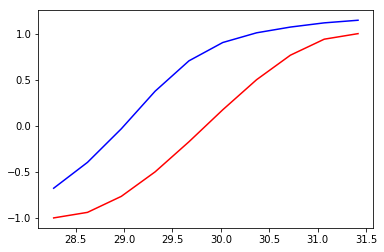

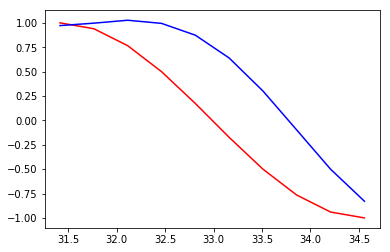

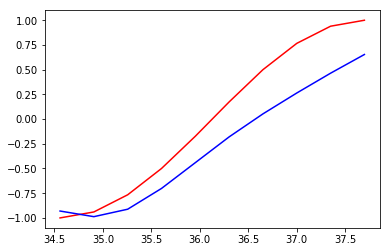

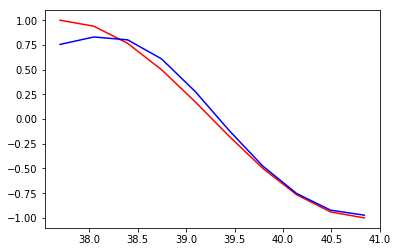

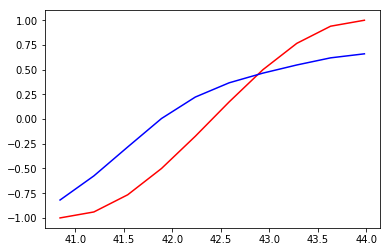

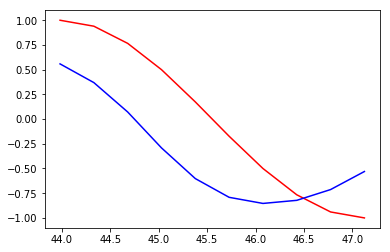

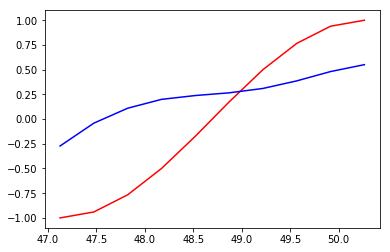

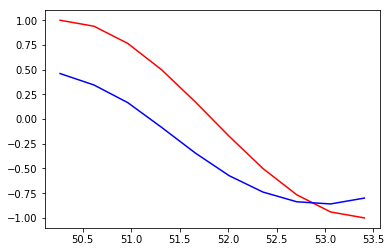

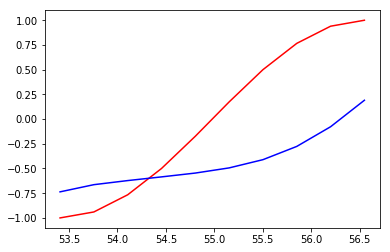

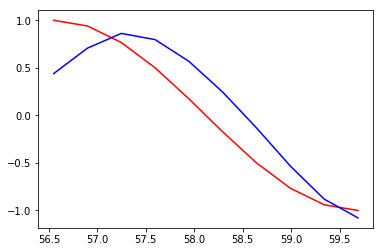

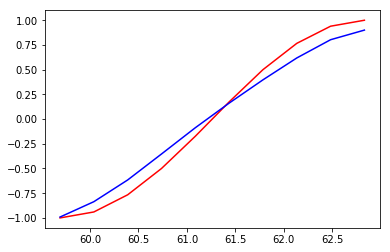

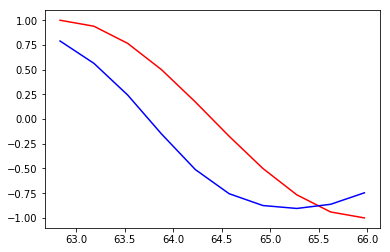

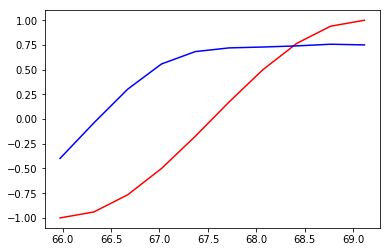

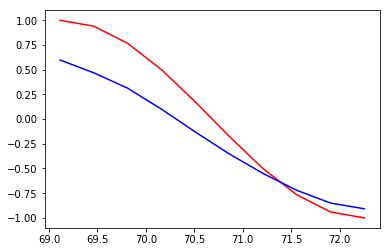

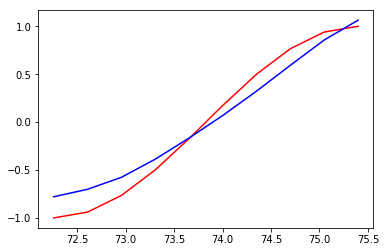

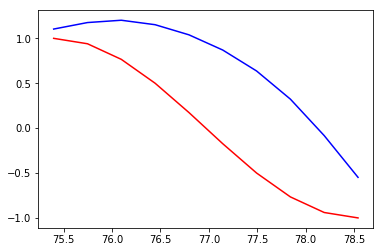

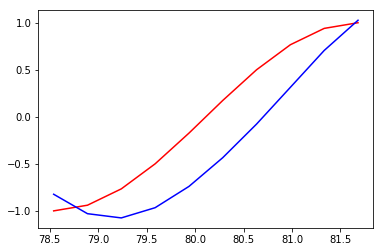

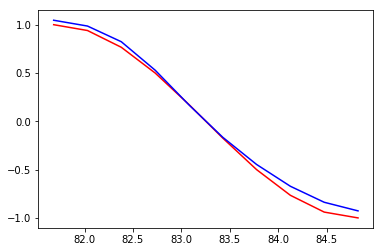

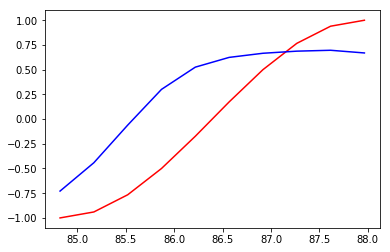

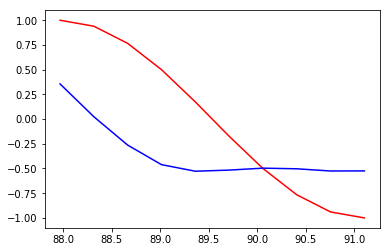

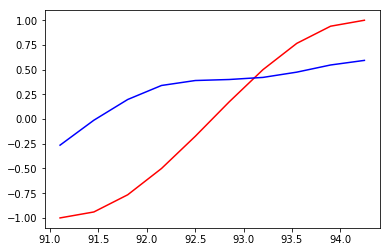

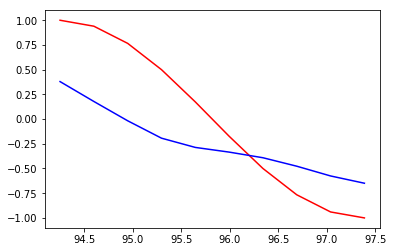

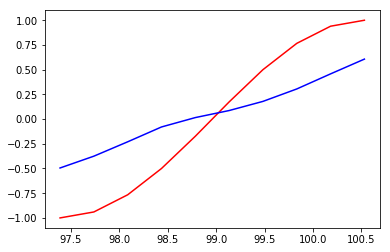

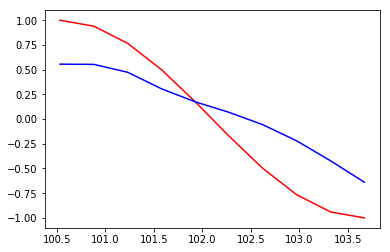

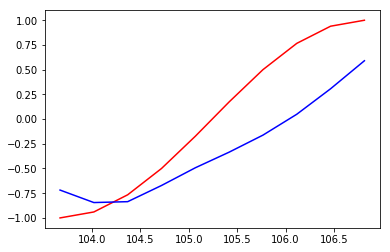

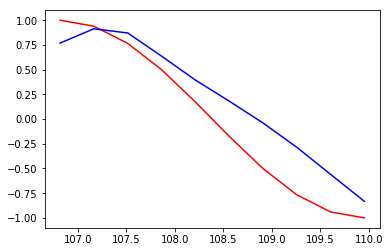

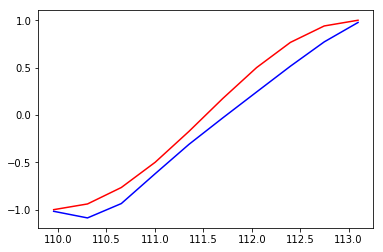

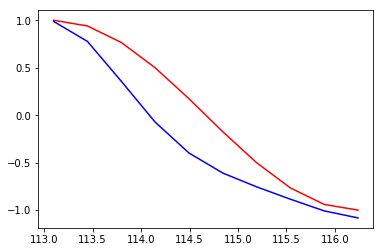

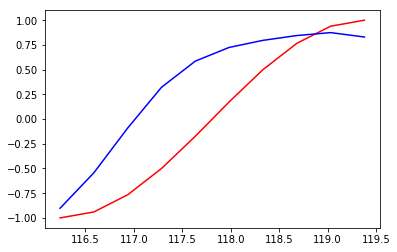

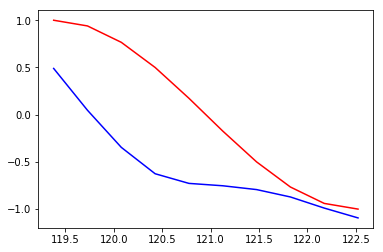

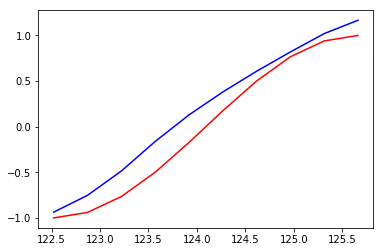

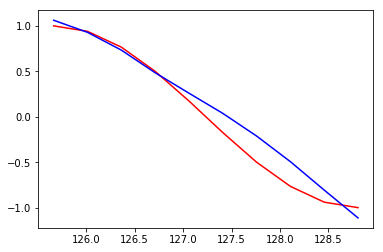

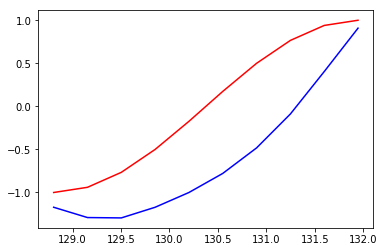

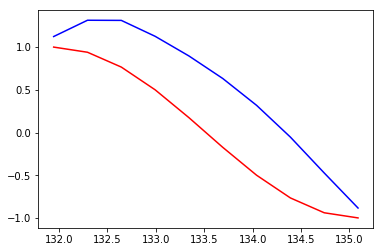

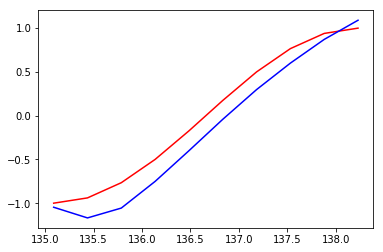

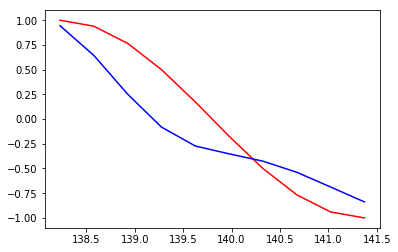

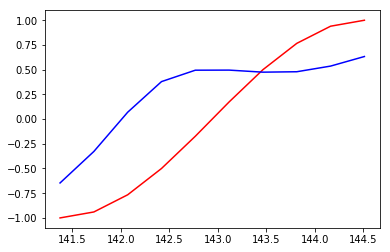

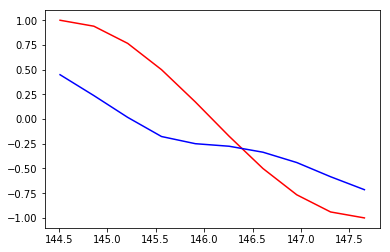

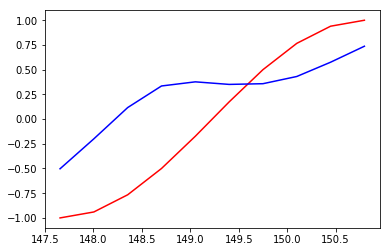

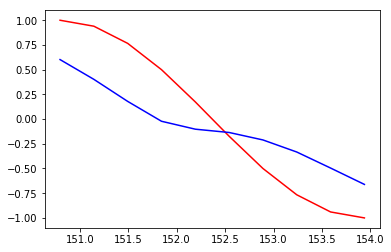

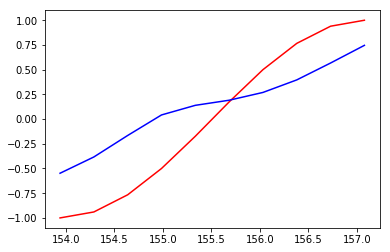

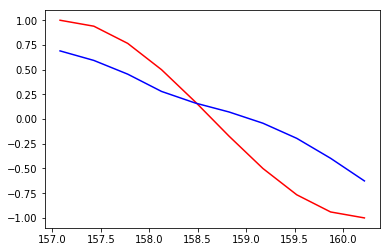

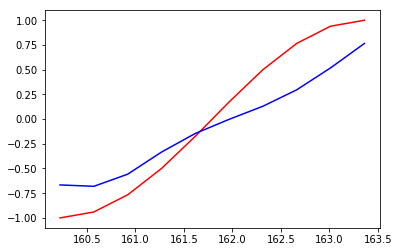

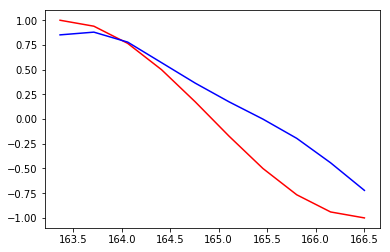

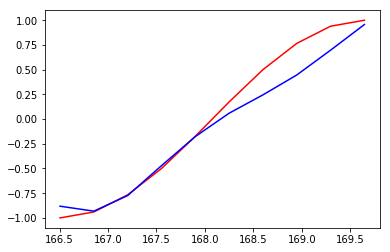

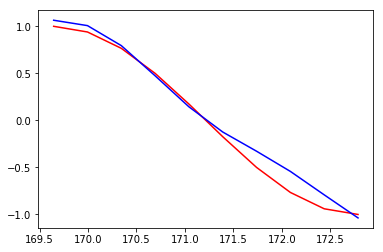

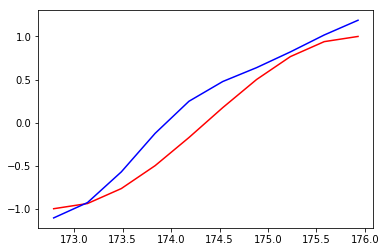

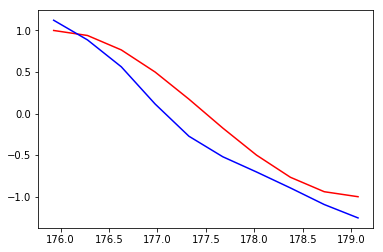

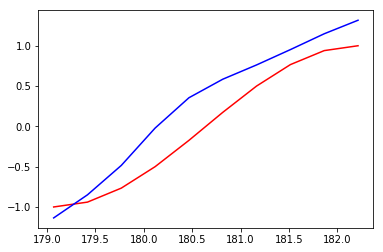

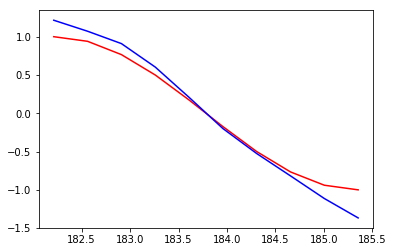

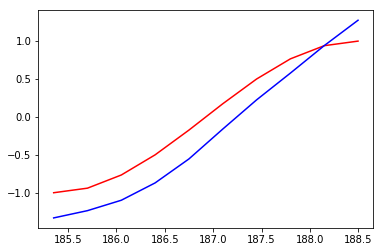

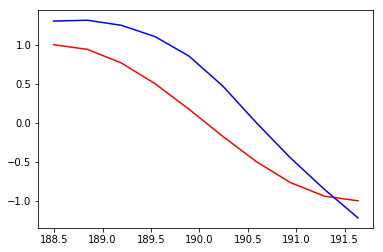

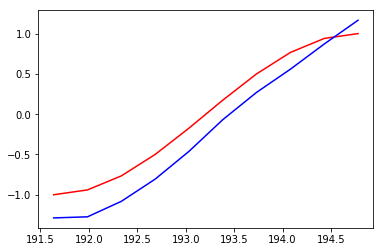

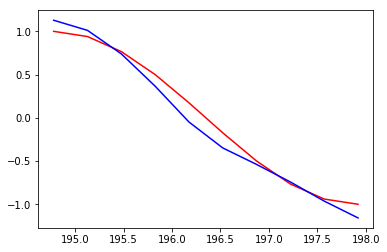

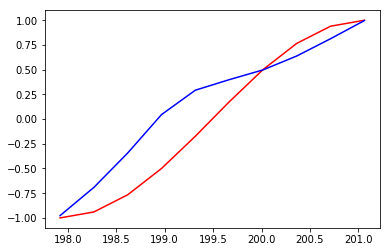

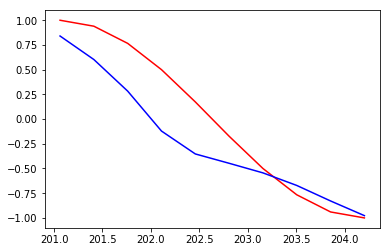

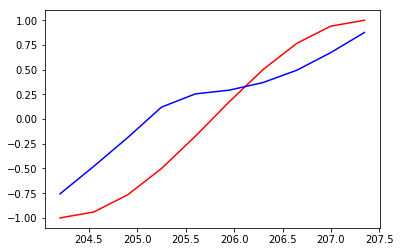

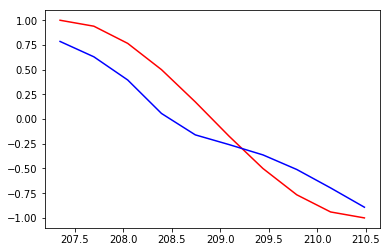

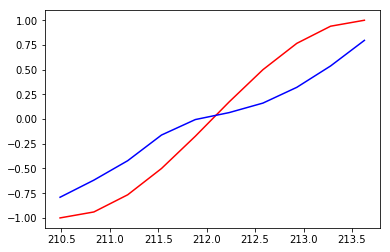

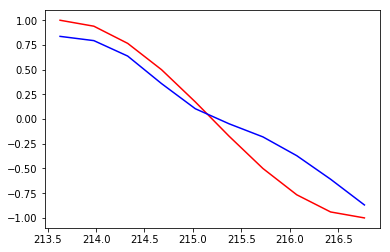

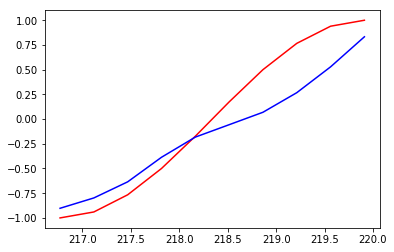

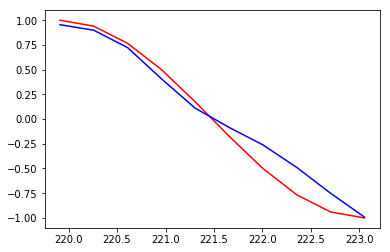

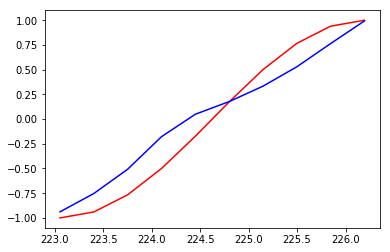

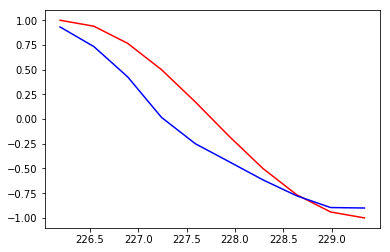

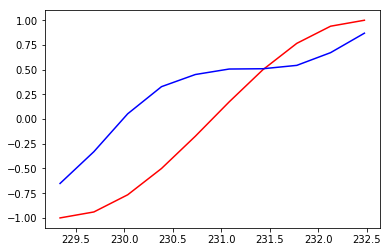

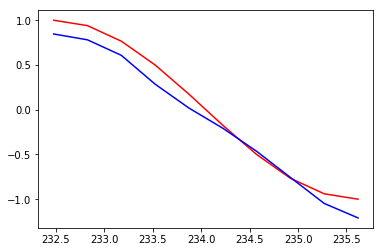

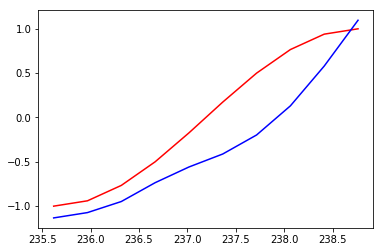

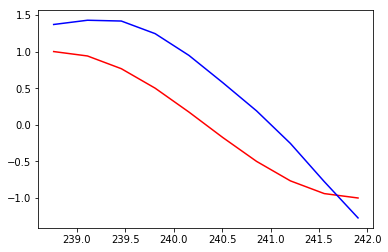

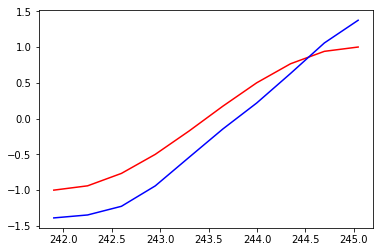

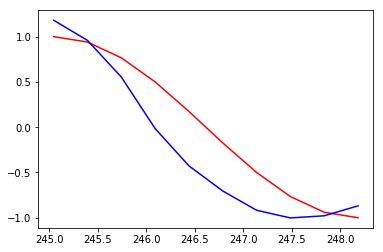

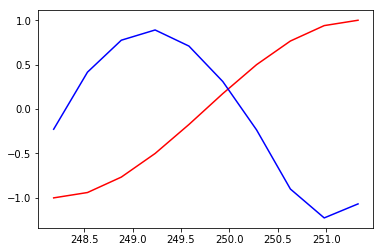

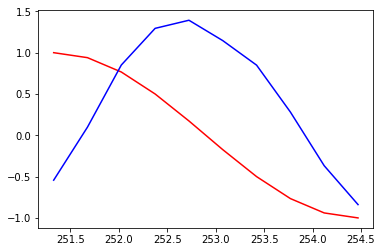

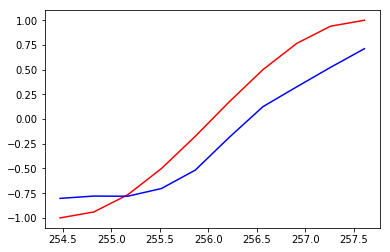

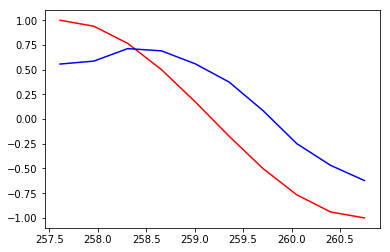

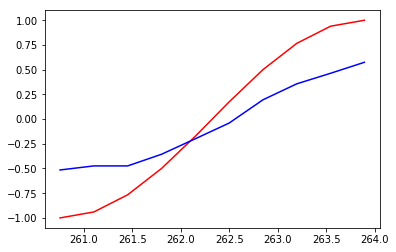

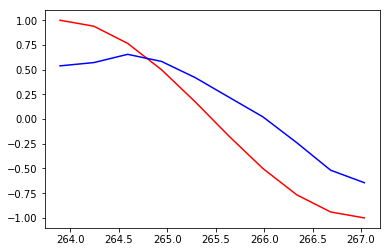

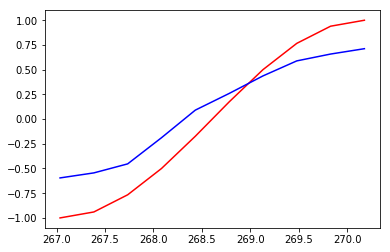

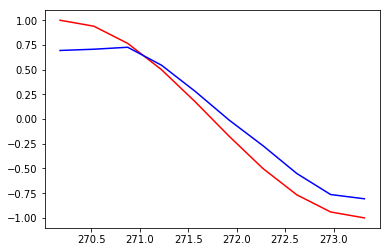

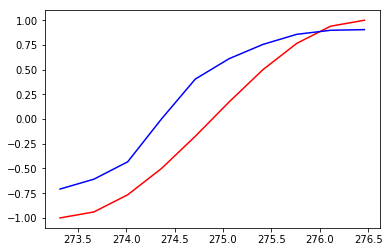

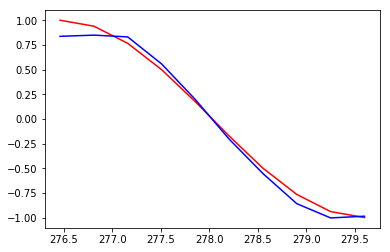

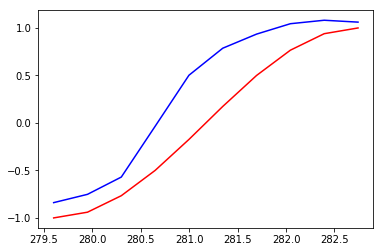

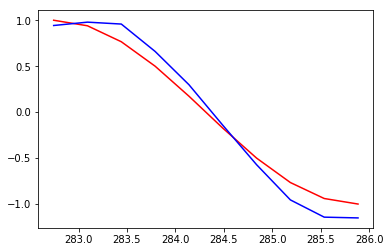

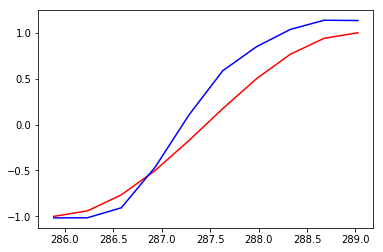

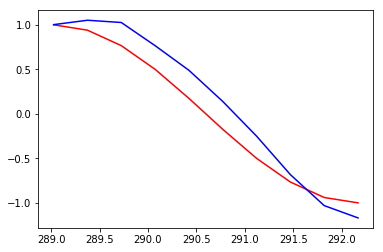

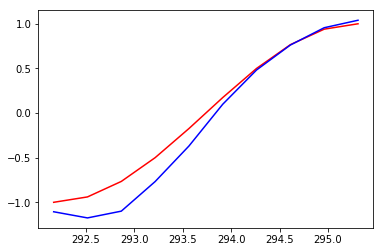

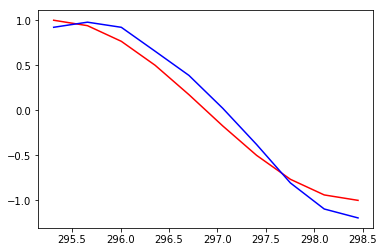

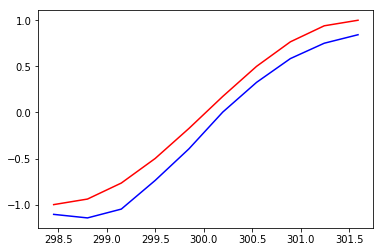

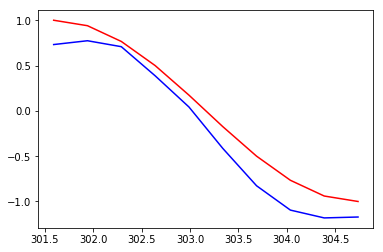

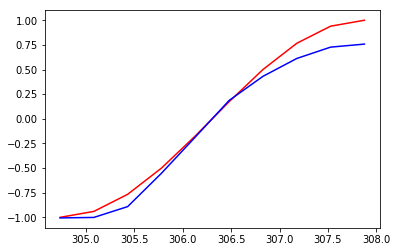

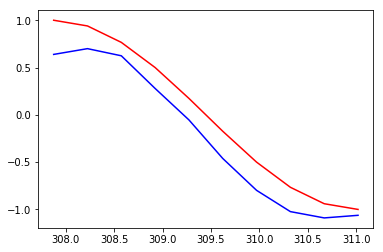

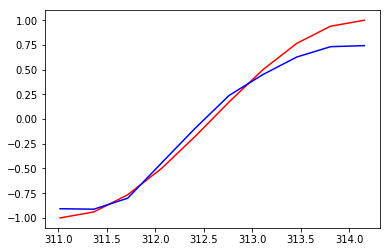

In [5]:
"""
View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou
Dependencies:
torch: 0.4
matplotlib
numpy
"""
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# torch.manual_seed(1)    # reproducible

# Hyper Parameters
TIME_STEP = 10      # rnn time step
INPUT_SIZE = 1      # rnn input size
LR = 0.02           # learning rate

# show data
steps = np.linspace(0, np.pi*2, 100, dtype=np.float32)
x_np = np.sin(steps)    # float32 for converting torch FloatTensor
y_np = np.cos(steps)
plt.plot(steps, y_np, 'r-', label='target (cos)')
plt.plot(steps, x_np, 'b-', label='input (sin)')
plt.legend(loc='best')
plt.show()


class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=32,     # rnn hidden unit
            num_layers=1,       # number of rnn layer
            batch_first=True,   # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )
        self.out = nn.Linear(32, 1)

    def forward(self, x, h_state):
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, hidden_size)
        r_out, h_state = self.rnn(x, h_state)

        outs = []    # save all predictions
        for time_step in range(r_out.size(1)):    # calculate output for each time step
            outs.append(self.out(r_out[:, time_step, :]))
        return torch.stack(outs, dim=1), h_state

        # instead, for simplicity, you can replace above codes by follows
        # r_out = r_out.view(-1, 32)
        # outs = self.out(r_out)
        # return outs, h_state

rnn = RNN()
print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.MSELoss()

h_state = None      # for initial hidden state

plt.figure(1, figsize=(12, 5))
plt.ion()           # continuously plot

for step in range(100):
    start, end = step * np.pi, (step+1)*np.pi   # time range
    # use sin predicts cos
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32)
    x_np = np.sin(steps)    # float32 for converting torch FloatTensor
    y_np = np.cos(steps)

    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis])    # shape (batch, time_step, input_size)
    y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis])

    prediction, h_state = rnn(x, h_state)   # rnn output
    # !! next step is important !!
    h_state = h_state.data        # repack the hidden state, break the connection from last iteration

    loss = loss_func(prediction, y)         # calculate loss
    optimizer.zero_grad()                   # clear gradients for this training step
    loss.backward()                         # backpropagation, compute gradients
    optimizer.step()                        # apply gradients

    # plotting
    plt.plot(steps, y_np.flatten(), 'r-')
    plt.plot(steps, prediction.data.numpy().flatten(), 'b-')
    plt.draw(); plt.pause(0.05)

plt.ioff()
plt.show()